In [2]:
%load_ext autoreload
%autoreload 2

In [21]:
import sys
sys.path.append(r"/Users/binxuwang/Github/Neuro-ActMax-GAN-comparison")
import pandas as pd
from os.path import join
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from core.utils.plot_utils import saveallforms
from neuro_data_analysis.neural_data_lib import load_neural_data, load_img_resp_pairs, load_latent_codes, pad_resp_traj
from neuro_data_analysis.neural_data_lib import load_neural_data, extract_all_evol_trajectory, extract_all_evol_trajectory_psth, extract_evol_activation_array, pad_psth_traj, get_expstr
from neuro_data_analysis.neural_data_utils import get_all_masks

### Figure 4A


In [4]:
source_data_root = r"/Users/binxuwang/Library/CloudStorage/OneDrive-HarvardUniversity/Manuscript_BigGAN/Submissions/Manuscript_BigGAN - NatNeuro/2025-10-Accepted-In-Principle-Docs/SourceData/"
source_data_dir = join(source_data_root, "Fig4_Source_data")

/var/folders/zc/krgdt7x11zvc_h0tv7k3mfdh0000gq/T/ipykernel_60198/1061307693.py:31: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


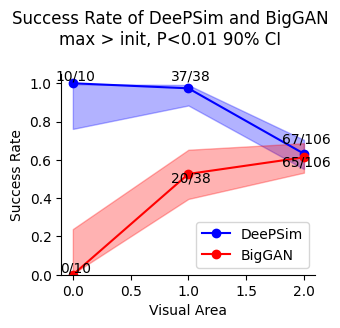

In [15]:
SR_df = pd.read_csv(join(source_data_dir, "Fig4A_SuccessRate_maxinit.csv"))
sucs_criterion_label, sucs_label = "max > init, P<0.01", "maxinit"
import json
with open(join(source_data_dir, "Fig4A_sucs_labels.txt"), "w") as f:
    json.dump({"sucs_criterion_label": sucs_criterion_label, 
               "sucs_label": sucs_label}, f, indent=2)


#%% Plot the success rate
fig, ax = plt.subplots(1, 1, figsize=[3.5, 3.3])
ax.plot(SR_df.index, SR_df.FC_rate, "o-", label="DeePSim", color="b")#"tab:blue"
ax.plot(SR_df.index, SR_df.BG_rate, "o-", label="BigGAN", color="r")#"tab:red"
ax.fill_between(SR_df.index, SR_df.FC_CI_1, SR_df.FC_CI_2, alpha=0.3, color="b")#"tab:blue"
ax.fill_between(SR_df.index, SR_df.BG_CI_1, SR_df.BG_CI_2, alpha=0.3, color="r")#"tab:red"
ax.set_ylim([0, 1.05])
ax.set_ylabel("Success Rate")
ax.set_xlabel("Visual Area")
# annotate the number of trials as fraction
for i, (label, row) in enumerate(SR_df.iterrows()):
    ax.annotate(f"{int(row.FC_suc)}/{int(row.total)}",
                xy=(i + 0.02, min(1.0, row.FC_rate+0.04)),
                ha="center", va="bottom", fontsize=10)
    ax.annotate(f"{int(row.BG_suc)}/{int(row.total)}",
                xy=(i + 0.02, max(0.0, row.BG_rate-0.06)),
                ha="center", va="bottom", fontsize=10)

ax.legend()
fig.suptitle(f"Success Rate of DeePSim and BigGAN\n{sucs_criterion_label} 90% CI")
fig.tight_layout()
# saveallforms(outdir, f"evol_{sucs_label}_success_rate_per_area_annot", fig, fmts=["png", "pdf", "svg"])
fig.show()

/var/folders/zc/krgdt7x11zvc_h0tv7k3mfdh0000gq/T/ipykernel_60198/2640972229.py:31: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


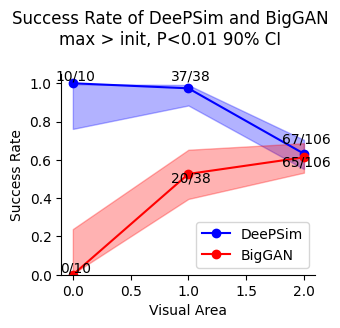

In [16]:
# Load the success rate source data for splitting by visual areas and GAN spaces
SR_df = pd.read_csv(join(source_data_dir, "Fig4A_SuccessRate_maxinit.csv"))
# SR_space_split_df = pd.read_csv(join(source_data_dir, "Fig4A_SuccessRate_space_split_maxinit.csv"), index_col=0)
with open(join(source_data_dir, "Fig4A_sucs_labels.txt"), "r") as f:
    file = json.load(f)
    sucs_criterion_label = file["sucs_criterion_label"]
    sucs_label = file["sucs_label"]

#%% Plot the success rate
fig, ax = plt.subplots(1, 1, figsize=[3.5, 3.3])
ax.plot(SR_df.index, SR_df.FC_rate, "o-", label="DeePSim", color="b")#"tab:blue"
ax.plot(SR_df.index, SR_df.BG_rate, "o-", label="BigGAN", color="r")#"tab:red"
ax.fill_between(SR_df.index, SR_df.FC_CI_1, SR_df.FC_CI_2, alpha=0.3, color="b")#"tab:blue"
ax.fill_between(SR_df.index, SR_df.BG_CI_1, SR_df.BG_CI_2, alpha=0.3, color="r")#"tab:red"
ax.set_ylim([0, 1.05])
ax.set_ylabel("Success Rate")
ax.set_xlabel("Visual Area")
# annotate the number of trials as fraction
for i, (label, row) in enumerate(SR_df.iterrows()):
    ax.annotate(f"{int(row.FC_suc)}/{int(row.total)}",
                xy=(i + 0.02, min(1.0, row.FC_rate+0.04)),
                ha="center", va="bottom", fontsize=10)
    ax.annotate(f"{int(row.BG_suc)}/{int(row.total)}",
                xy=(i + 0.02, max(0.0, row.BG_rate-0.06)),
                ha="center", va="bottom", fontsize=10)

ax.legend()
fig.suptitle(f"Success Rate of DeePSim and BigGAN\n{sucs_criterion_label} 90% CI")
fig.tight_layout()
# saveallforms(outdir, f"evol_{sucs_label}_success_rate_per_area_annot", fig, fmts=["png", "pdf", "svg"])
fig.show()

### Figure 4B

In [40]:
from scipy.stats import ttest_rel, ttest_ind
def paired_strip_plot_simple(col1, col2, msk=None, col1_err=None, col2_err=None, ax=None,
                             offset=0, jitter_std=0.1):
    if msk is None:
        msk = np.ones(len(col1), dtype=bool)
    vec1 = col1[msk]
    vec2 = col2[msk]
    xjitter = jitter_std * np.random.randn(len(vec1))
    if ax is None:
        figh, ax = plt.subplots(1,1,figsize=[4, 6])
    else:
        figh = ax.figure
    ax.scatter(offset + xjitter, vec1, color="blue", alpha=0.3)
    ax.scatter(offset + xjitter+1, vec2, color="red", alpha=0.3)
    if col1_err is not None:
        ax.errorbar(offset + xjitter, vec1, yerr=col1_err[msk],
                    fmt="none", color="blue", alpha=0.3)
    if col2_err is not None:
        ax.errorbar(offset + xjitter+1, vec2, yerr=col2_err[msk],
                    fmt="none", color="red", alpha=0.3)
    ax.plot(offset + np.arange(2)[:, None]+xjitter[None, :],
             np.stack((vec1, vec2)), color="k", alpha=0.1)
    # plt.xticks([0,1], [col1, col2])
    tval, pval = ttest_rel(vec1, vec2)
    # tval, pval = ttest_rel_df(df, msk, col1, col2)
    ax.set_title(f"tval={tval:.3f}, pval={pval:.1e} N={msk.sum()}")
    # annotate the string on top of the plot
    ax.text(offset+0.5, 1.1, f"t={tval:.3f}, P={pval:.1e}\nN={msk.sum()}",
            ha='center', va='center')
    # figh.show()
    return figh


In [24]:
# tabdir = r"E:\OneDrive - Harvard University\Manuscript_BigGAN\Stats_tables"
tabdir = r'/Users/binxuwang/Library/CloudStorage/OneDrive-HarvardUniversity/Manuscript_BigGAN/Stats_tables'
""" Trajectory synopsis with all areas """
_, BFEStats = load_neural_data()
resp_col, _ = extract_all_evol_trajectory(BFEStats, )
resp_extrap_arr, extrap_mask_arr, max_len = pad_resp_traj(resp_col)
normresp_extrap_arr = resp_extrap_arr / resp_extrap_arr[:, :, 0:2].max(axis=(1,2), keepdims=True)
meta_act_df = pd.read_csv(join(tabdir, "meta_activation_stats_w_optimizer.csv"), index_col=False)
meta_df = pd.read_csv(join(tabdir, "meta_stats_w_optimizer.csv"), index_col=False)


Amsk, Bmsk, V1msk, V4msk, ITmsk, \
    length_msk, spc_msk, sucsmsk, \
    bsl_unstable_msk, bsl_stable_msk, validmsk = get_all_masks(meta_df)

Exp 003 Beto-22072020-002 Pref chan5 U2
image size [3. 3.] deg  pos [-0.7  1. ]
Evol thr0: fc6   thr1: BigGAN_class
Exp 004 Beto-22072020-003 Pref chan5 U2
image size [6. 6.] deg  pos [-0.7  1. ]
Evol thr0: BigGAN_class   thr1: BigGAN_class
Exp 005 Beto-23072020-002 Pref chan29 U2
image size [3. 3.] deg  pos [-0.8  1. ]
Evol thr0: fc6   thr1: BigGAN_class
Exp 006 Beto-27072020-002 Pref chan26 U1
image size [3. 3.] deg  pos [-1.1  0. ]
Evol thr0: fc6   thr1: BigGAN_class
Exp 007 Beto-28072020-003 Pref chan15 U1
image size [3. 3.] deg  pos [-0.5  1. ]
Evol thr0: fc6   thr1: BigGAN
Exp 008 Beto-28072020-006 Pref chan15 U1
image size [3. 3.] deg  pos [-0.5  1. ]
Evol thr0: BigGAN_class   thr1: BigGAN
Exp 009 Beto-29072020-002 Pref chan28 U1
image size [3. 3.] deg  pos [0.  0.5]
Evol thr0: fc6   thr1: BigGAN_class
Exp 010 Beto-29072020-003 Pref chan18 U1
image size [4. 4.] deg  pos [-0.5  1. ]
Evol thr0: fc6   thr1: BigGAN_class
Exp 012 Beto-31072020-003 Pref chan29 U2
image size [3. 3.] de

/var/folders/zc/krgdt7x11zvc_h0tv7k3mfdh0000gq/T/ipykernel_60198/2708581864.py:30: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  figh.show()
/var/folders/zc/krgdt7x11zvc_h0tv7k3mfdh0000gq/T/ipykernel_60198/2708581864.py:48: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  figh.show()


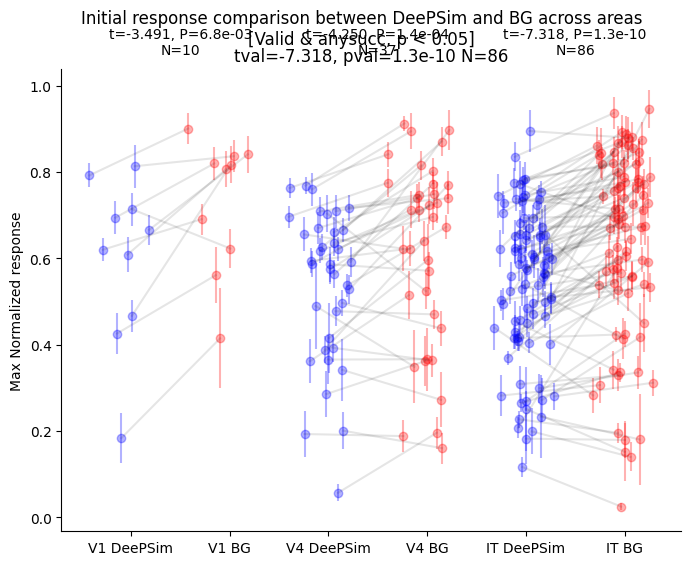

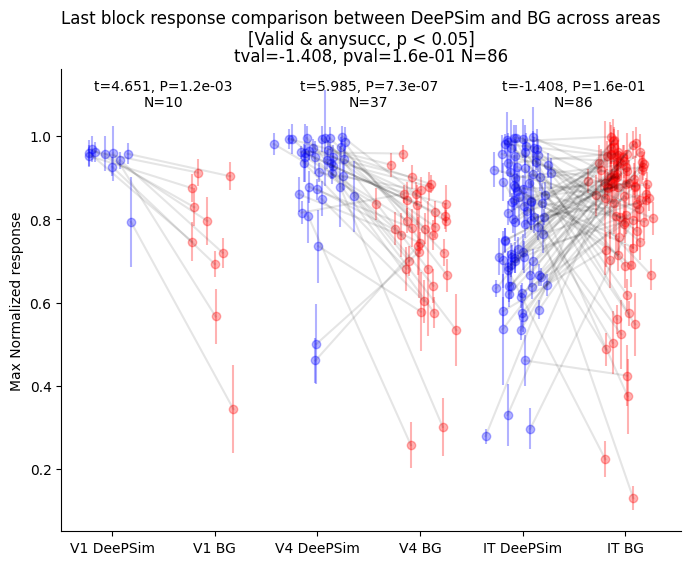

In [ ]:
"""Mass produce figures for difference success mask and p threshold"""
p_thresh = 0.05
FCsucsmsk = meta_df.p_maxinit_0 < p_thresh
BGsucsmsk = meta_df.p_maxinit_1 < p_thresh
bothsucsmsk = FCsucsmsk & BGsucsmsk
nonesucsmsk = (~FCsucsmsk) & (~BGsucsmsk)
anysucsmsk = FCsucsmsk | BGsucsmsk
p_str = str(p_thresh).replace('.','')

for succ_label, success_mask in zip(["anysucc",], [anysucsmsk,]):
    msk_general, label_general = validmsk & success_mask, f"val_{succ_label}"
    #%
    """Paired strip plot of initial block activation, seperated into the three visual areas"""
    figh, ax = plt.subplots(1, 1, figsize=[8, 6])
    paired_strip_plot_simple(normresp_extrap_arr[:, 0, 0], normresp_extrap_arr[:, 0, 1],
                 col1_err=normresp_extrap_arr[:, 0, 2], col2_err=normresp_extrap_arr[:, 0, 3],
                 msk=V1msk & msk_general, ax=ax, offset=0, jitter_std=0.15)
    paired_strip_plot_simple(normresp_extrap_arr[:, 0, 0], normresp_extrap_arr[:, 0, 1],
                 col1_err=normresp_extrap_arr[:, 0, 2], col2_err=normresp_extrap_arr[:, 0, 3],
                 msk=V4msk & msk_general, ax=ax, offset=2, jitter_std=0.15)
    paired_strip_plot_simple(normresp_extrap_arr[:, 0, 0], normresp_extrap_arr[:, 0, 1],
                 col1_err=normresp_extrap_arr[:, 0, 2], col2_err=normresp_extrap_arr[:, 0, 3],
                 msk=ITmsk & msk_general, ax=ax, offset=4, jitter_std=0.15)
    ax.set_xticks([0, 1, 2, 3, 4, 5])
    ax.set_xticklabels(["V1 DeePSim", "V1 BG", "V4 DeePSim", "V4 BG", "IT DeePSim", "IT BG"])
    ax.set_ylabel("Max Normalized response")
    figh.suptitle(f"Initial response comparison between DeePSim and BG across areas\n[Valid & {succ_label}, p < {p_thresh}]")
    # saveallforms(outdir, f"maxnorm_initresp_cmp_{label_general}_p{p_str}_areasep", figh)
    figh.show()

    """Paired strip plot of end block activation, seperated into the three visual areas"""
    figh, ax = plt.subplots(1, 1, figsize=[8, 6])
    paired_strip_plot_simple(normresp_extrap_arr[:, -1, 0], normresp_extrap_arr[:, -1, 1],
                col1_err=normresp_extrap_arr[:, -1, 2], col2_err=normresp_extrap_arr[:, -1, 3],
                msk=V1msk & msk_general, ax=ax, offset=0, jitter_std=0.15)
    paired_strip_plot_simple(normresp_extrap_arr[:, -1, 0], normresp_extrap_arr[:, -1, 1],
                col1_err=normresp_extrap_arr[:, -1, 2], col2_err=normresp_extrap_arr[:, -1, 3],
                msk=V4msk & msk_general, ax=ax, offset=2, jitter_std=0.15)
    paired_strip_plot_simple(normresp_extrap_arr[:, -1, 0], normresp_extrap_arr[:, -1, 1],
                col1_err=normresp_extrap_arr[:, -1, 2], col2_err=normresp_extrap_arr[:, -1, 3],
                msk=ITmsk & msk_general, ax=ax, offset=4, jitter_std=0.15)
    ax.set_xticks([0, 1, 2, 3, 4, 5])
    ax.set_xticklabels(["V1 DeePSim", "V1 BG", "V4 DeePSim", "V4 BG", "IT DeePSim", "IT BG"])
    ax.set_ylabel("Max Normalized response")
    figh.suptitle(f"Last block response comparison between DeePSim and BG across areas\n[Valid & {succ_label}, p < {p_thresh}]")
    # saveallforms(outdir, f"maxnorm_endresp_cmp_{label_general}_p{p_str}_areasep", figh)
    figh.show()

In [ ]:
for slice_i, slice_label in enumerate(["DeePSim_mean", "BigGAN_mean", "DeePSim_sem", "BigGAN_sem"]):
    slice_arr = normresp_extrap_arr[:, :, slice_i]
    slice_df = pd.DataFrame(slice_arr) # exp id by block number matrix
    slice_df.to_csv(join(source_data_dir, f"Figure4_src_maxnorm_resp_stats_all_exps_{slice_label}_data.csv"), index=False)

p_thresh = 0.05
FCsucsmsk = meta_df.p_maxinit_0 < p_thresh
BGsucsmsk = meta_df.p_maxinit_1 < p_thresh
bothsucsmsk = FCsucsmsk & BGsucsmsk
nonesucsmsk = (~FCsucsmsk) & (~BGsucsmsk)
anysucsmsk = FCsucsmsk | BGsucsmsk
mask_df = pd.DataFrame({
    "valid": validmsk.astype(int),
    "FCsucc005": FCsucsmsk.astype(int),
    "BGsucc005": BGsucsmsk.astype(int),
    "bothsucc005": bothsucsmsk.astype(int),
    "nonesucc005": nonesucsmsk.astype(int),
    "anysucc005": anysucsmsk.astype(int),
    "V1msk": V1msk.astype(int),
    "V4msk": V4msk.astype(int),
    "ITmsk": ITmsk.astype(int),
})
p_thresh = 0.01
FCsucsmsk = meta_df.p_maxinit_0 < p_thresh
BGsucsmsk = meta_df.p_maxinit_1 < p_thresh
bothsucsmsk = FCsucsmsk & BGsucsmsk
nonesucsmsk = (~FCsucsmsk) & (~BGsucsmsk)
anysucsmsk = FCsucsmsk | BGsucsmsk
mask_df["FCsucc001"] = FCsucsmsk.astype(int)
mask_df["BGsucc001"] = BGsucsmsk.astype(int)
mask_df["bothsucc001"] = bothsucsmsk.astype(int)
mask_df["nonesucc001"] = nonesucsmsk.astype(int)
mask_df["anysucc001"] = anysucsmsk.astype(int)
mask_df.to_csv(join(source_data_dir, f"Figure4_src_exp_masks_and_succ_labels.csv"), index=False)

#### Testing loading is fine

/var/folders/zc/krgdt7x11zvc_h0tv7k3mfdh0000gq/T/ipykernel_60198/2623440404.py:43: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  figh.show()
/var/folders/zc/krgdt7x11zvc_h0tv7k3mfdh0000gq/T/ipykernel_60198/2623440404.py:61: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  figh.show()


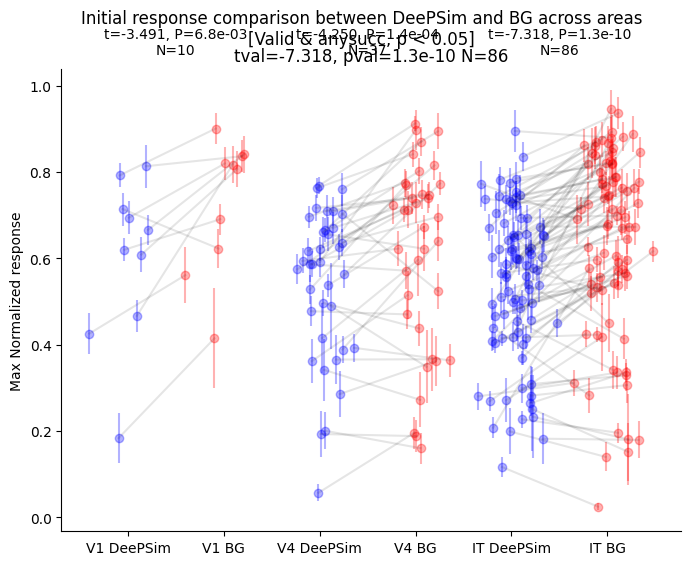

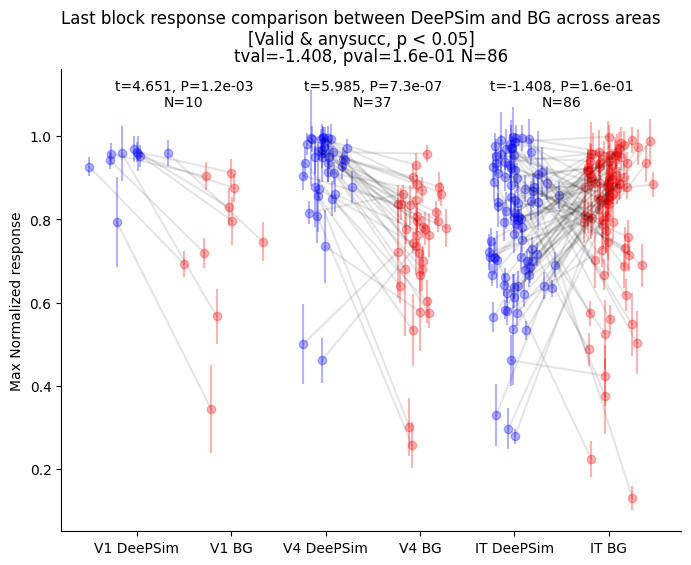

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from os.path import join

# Load the source data
# Adjust as needed if source_data_dir is not already defined in this notebook
if 'source_data_dir' not in locals():
    source_data_dir = "./"

# Load normresp extrap arrays for each stat
dee_sim_mean = pd.read_csv(join(source_data_dir, "Figure4_src_maxnorm_resp_stats_all_exps_DeePSim_mean_data.csv")).values
biggan_mean = pd.read_csv(join(source_data_dir, "Figure4_src_maxnorm_resp_stats_all_exps_BigGAN_mean_data.csv")).values
dee_sim_sem = pd.read_csv(join(source_data_dir, "Figure4_src_maxnorm_resp_stats_all_exps_DeePSim_sem_data.csv")).values
biggan_sem = pd.read_csv(join(source_data_dir, "Figure4_src_maxnorm_resp_stats_all_exps_BigGAN_sem_data.csv")).values

# Compose reconstructed array - (n_exp, n_block, 4)
normresp_extrap_arr_csv = np.stack([dee_sim_mean, biggan_mean, dee_sim_sem, biggan_sem], axis=-1)
# Load mask and area labels
mask_df = pd.read_csv(join(source_data_dir, f"Figure4_src_exp_masks_and_succ_labels.csv"))
validmsk = mask_df["valid"].astype(bool).values
V1msk = mask_df["V1msk"].astype(bool).values
V4msk = mask_df["V4msk"].astype(bool).values
ITmsk = mask_df["ITmsk"].astype(bool).values
# Pull other masks as example (pick "anysucc")
anysucsmsk = mask_df["anysucc005"].astype(bool).values
msk_general, label_general, succ_label, p_thresh = validmsk & anysucsmsk, f"val_anysucc", "anysucc", 0.05
figh, ax = plt.subplots(1, 1, figsize=[8, 6])
paired_strip_plot_simple(normresp_extrap_arr[:, 0, 0], normresp_extrap_arr[:, 0, 1],
                col1_err=normresp_extrap_arr[:, 0, 2], col2_err=normresp_extrap_arr[:, 0, 3],
                msk=V1msk & msk_general, ax=ax, offset=0, jitter_std=0.15)
paired_strip_plot_simple(normresp_extrap_arr[:, 0, 0], normresp_extrap_arr[:, 0, 1],
                col1_err=normresp_extrap_arr[:, 0, 2], col2_err=normresp_extrap_arr[:, 0, 3],
                msk=V4msk & msk_general, ax=ax, offset=2, jitter_std=0.15)
paired_strip_plot_simple(normresp_extrap_arr[:, 0, 0], normresp_extrap_arr[:, 0, 1],
                col1_err=normresp_extrap_arr[:, 0, 2], col2_err=normresp_extrap_arr[:, 0, 3],
                msk=ITmsk & msk_general, ax=ax, offset=4, jitter_std=0.15)
ax.set_xticks([0, 1, 2, 3, 4, 5])
ax.set_xticklabels(["V1 DeePSim", "V1 BG", "V4 DeePSim", "V4 BG", "IT DeePSim", "IT BG"])
ax.set_ylabel("Max Normalized response")
figh.suptitle(f"Initial response comparison between DeePSim and BG across areas\n[Valid & {succ_label}, p < {p_thresh}]")
# saveallforms(outdir, f"maxnorm_initresp_cmp_{label_general}_p{p_str}_areasep", figh)
figh.show()

"""Paired strip plot of end block activation, seperated into the three visual areas"""
figh, ax = plt.subplots(1, 1, figsize=[8, 6])
paired_strip_plot_simple(normresp_extrap_arr[:, -1, 0], normresp_extrap_arr[:, -1, 1],
            col1_err=normresp_extrap_arr[:, -1, 2], col2_err=normresp_extrap_arr[:, -1, 3],
            msk=V1msk & msk_general, ax=ax, offset=0, jitter_std=0.15)
paired_strip_plot_simple(normresp_extrap_arr[:, -1, 0], normresp_extrap_arr[:, -1, 1],
            col1_err=normresp_extrap_arr[:, -1, 2], col2_err=normresp_extrap_arr[:, -1, 3],
            msk=V4msk & msk_general, ax=ax, offset=2, jitter_std=0.15)
paired_strip_plot_simple(normresp_extrap_arr[:, -1, 0], normresp_extrap_arr[:, -1, 1],
            col1_err=normresp_extrap_arr[:, -1, 2], col2_err=normresp_extrap_arr[:, -1, 3],
            msk=ITmsk & msk_general, ax=ax, offset=4, jitter_std=0.15)
ax.set_xticks([0, 1, 2, 3, 4, 5])
ax.set_xticklabels(["V1 DeePSim", "V1 BG", "V4 DeePSim", "V4 BG", "IT DeePSim", "IT BG"])
ax.set_ylabel("Max Normalized response")
figh.suptitle(f"Last block response comparison between DeePSim and BG across areas\n[Valid & {succ_label}, p < {p_thresh}]")
# saveallforms(outdir, f"maxnorm_endresp_cmp_{label_general}_p{p_str}_areasep", figh)
figh.show()

### Figure 4C

In [46]:
import pandas as pd
# Save the extrap_mask_arr to disk as a CSV file using pandas
pd.DataFrame(extrap_mask_arr.astype(int)).to_csv(join(source_data_dir, "Figure4_src_extrapolation_mask_arr.csv"), index=False, header=False)
# Demonstrate reloading to verify
loaded_extrap_mask_arr = pd.read_csv(join(source_data_dir, "Figure4_src_extrapolation_mask_arr.csv"), header=None).values.astype(bool)
print("Loaded array has shape:", loaded_extrap_mask_arr.shape)
print("Arrays are equal:", np.array_equal(extrap_mask_arr, loaded_extrap_mask_arr))

Loaded array has shape: (170, 56)
Arrays are equal: True


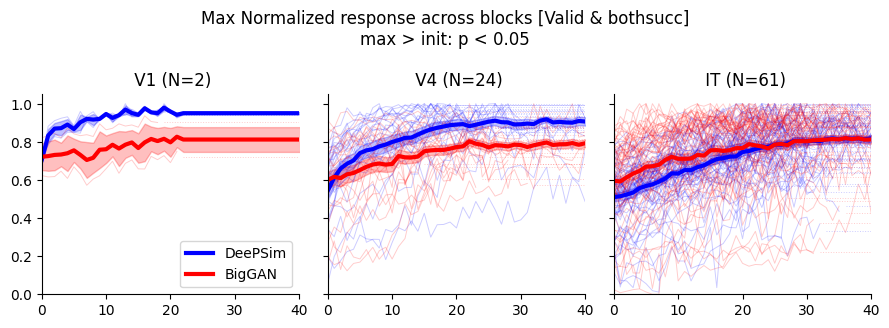

In [49]:
#%% Final mass production script
p_thresh = 0.05
FCsucsmsk = meta_df.p_maxinit_0 < p_thresh
BGsucsmsk = meta_df.p_maxinit_1 < p_thresh
bothsucsmsk = FCsucsmsk & BGsucsmsk
anysucsmsk = FCsucsmsk | BGsucsmsk
nonesucsmsk = (~FCsucsmsk) & (~BGsucsmsk)
p_str = str(p_thresh).replace('.','')
for succ_label, success_mask in zip(["bothsucc", ], [bothsucsmsk, ]):
    figh, axs = plt.subplots(1, 3, figsize=(9, 3.3), sharey="row", sharex='col', squeeze=False)
    rowi = 0
    msk_major = True # Amsk | Bmsk
    label_major = ""
    for colj, (msk_minor, lable_minor) in enumerate(zip([V1msk, V4msk, ITmsk],
                                              ["V1", "V4", "IT"])):
        msk = (msk_major & msk_minor & validmsk & success_mask).to_numpy()
        # naive plot
        # axs[rowi, colj].plot(normresp_extrap_arr[msk, :, 0].T, color="blue", alpha=0.2, lw=0.7)
        # axs[rowi, colj].plot(normresp_extrap_arr[msk, :, 1].T, color="red", alpha=0.2, lw=0.7)
        # plot with dashed lines for extrapolated values
        normresp_extrap_arr_nan = normresp_extrap_arr.copy()
        normresp_extrap_arr_nan[~extrap_mask_arr, 0] = np.nan
        normresp_extrap_arr_nan[~extrap_mask_arr, 1] = np.nan
        axs[rowi, colj].plot(normresp_extrap_arr_nan[msk, :, 0].T, color="blue", alpha=0.2, lw=0.7)
        axs[rowi, colj].plot(normresp_extrap_arr_nan[msk, :, 1].T, color="red", alpha=0.2, lw=0.7)
        normresp_extrap_fill_nan = normresp_extrap_arr.copy()
        normresp_extrap_fill_nan[extrap_mask_arr, 0] = np.nan
        normresp_extrap_fill_nan[extrap_mask_arr, 1] = np.nan
        axs[rowi, colj].plot(normresp_extrap_fill_nan[msk, :, 0].T, color="blue", alpha=0.2, lw=0.7, linestyle=":")
        axs[rowi, colj].plot(normresp_extrap_fill_nan[msk, :, 1].T, color="red", alpha=0.2, lw=0.7, linestyle=":")

        mean_trace_FC = normresp_extrap_arr[msk, :, 0].mean(axis=0)
        sem_trace_FC = normresp_extrap_arr[msk, :, 0].std(axis=0) / np.sqrt(msk.sum())
        mean_trace_BG = normresp_extrap_arr[msk, :, 1].mean(axis=0)
        sem_trace_BG = normresp_extrap_arr[msk, :, 1].std(axis=0) / np.sqrt(msk.sum())
        axs[rowi, colj].plot(mean_trace_FC, color="blue", lw=3, label="DeePSim" if colj == 0 else None)
        axs[rowi, colj].fill_between(np.arange(len(mean_trace_FC)),
                                        mean_trace_FC-sem_trace_FC,
                                        mean_trace_FC+sem_trace_FC,
                                        color="blue", alpha=0.25)
        axs[rowi, colj].plot(mean_trace_BG, color="red", lw=3, label="BigGAN" if rowi == 0 else None)
        axs[rowi, colj].fill_between(np.arange(len(mean_trace_BG)),
                                        mean_trace_BG-sem_trace_BG,
                                        mean_trace_BG+sem_trace_BG,
                                        color="red", alpha=0.25)
        axs[rowi, colj].set_title(f"{label_major} {lable_minor} (N={msk.sum()})")
        if rowi == 0 and colj == 0:
            axs[rowi, colj].legend(loc="lower right")

    for ax in axs.ravel():
        ax.set_xlim([0, 40])

    plt.suptitle(f"Max Normalized response across blocks [Valid & {succ_label}]\nmax > init: p < {p_thresh}")
    plt.tight_layout()
    # saveallforms(figdir, f"maxnorm_resp_traj_val_{succ_label}_area_sep_p{p_str}", figh=figh)
    # plt.show()

    for ax in axs.ravel():
        ax.set_ylim([0, 1.05])

    # saveallforms(figdir, f"maxnorm_resp_traj_val_{succ_label}_area_sep_p{p_str}_ylim01", figh=figh)
    plt.show()

### Test reproduction 

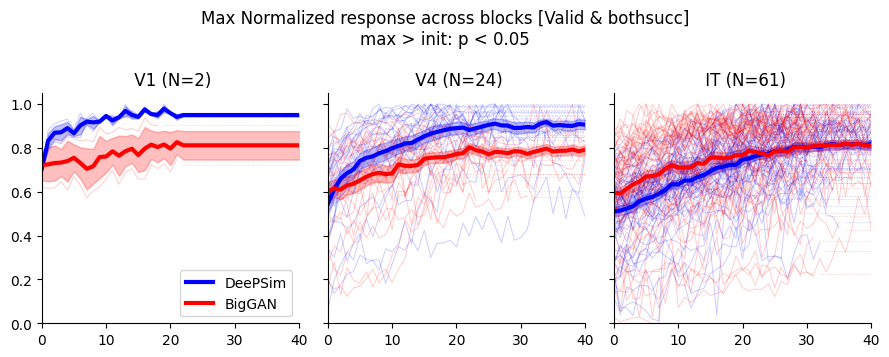

In [52]:
# Load normresp extrap arrays for each stat
dee_sim_mean = pd.read_csv(join(source_data_dir, "Figure4_src_maxnorm_resp_stats_all_exps_DeePSim_mean_data.csv")).values
biggan_mean = pd.read_csv(join(source_data_dir, "Figure4_src_maxnorm_resp_stats_all_exps_BigGAN_mean_data.csv")).values
dee_sim_sem = pd.read_csv(join(source_data_dir, "Figure4_src_maxnorm_resp_stats_all_exps_DeePSim_sem_data.csv")).values
biggan_sem = pd.read_csv(join(source_data_dir, "Figure4_src_maxnorm_resp_stats_all_exps_BigGAN_sem_data.csv")).values
# Compose reconstructed array - (n_exp, n_block, 4)
normresp_extrap_arr_csv = np.stack([dee_sim_mean, biggan_mean, dee_sim_sem, biggan_sem], axis=-1)
extrap_mask_arr = pd.read_csv(join(source_data_dir, "Figure4_src_extrapolation_mask_arr.csv"), header=None).values.astype(bool)
# Load mask and area labels
mask_df = pd.read_csv(join(source_data_dir, f"Figure4_src_exp_masks_and_succ_labels.csv"))
validmsk = mask_df["valid"].astype(bool).values
V1msk = mask_df["V1msk"].astype(bool).values
V4msk = mask_df["V4msk"].astype(bool).values
ITmsk = mask_df["ITmsk"].astype(bool).values
# Pull other masks as example (pick "anysucc")
bothsucsmsk = mask_df["bothsucc005"].astype(bool).values
success_mask = bothsucsmsk

figh, axs = plt.subplots(1, 3, figsize=(9, 3.6), sharey="row", sharex='col', squeeze=False)
rowi = 0
msk_major = True # Amsk | Bmsk
label_major = ""
for colj, (msk_minor, lable_minor) in enumerate(zip([V1msk, V4msk, ITmsk],
                                                    ["V1", "V4", "IT"])):
    msk = (msk_major & msk_minor & validmsk & success_mask)#.to_numpy()
    # plot with dashed lines for extrapolated values
    normresp_extrap_arr_nan = normresp_extrap_arr.copy()
    normresp_extrap_arr_nan[~extrap_mask_arr, 0] = np.nan
    normresp_extrap_arr_nan[~extrap_mask_arr, 1] = np.nan
    axs[rowi, colj].plot(normresp_extrap_arr_nan[msk, :, 0].T, color="blue", alpha=0.2, lw=0.7)
    axs[rowi, colj].plot(normresp_extrap_arr_nan[msk, :, 1].T, color="red", alpha=0.2, lw=0.7)
    normresp_extrap_fill_nan = normresp_extrap_arr.copy()
    normresp_extrap_fill_nan[extrap_mask_arr, 0] = np.nan
    normresp_extrap_fill_nan[extrap_mask_arr, 1] = np.nan
    axs[rowi, colj].plot(normresp_extrap_fill_nan[msk, :, 0].T, color="blue", alpha=0.2, lw=0.7, linestyle=":")
    axs[rowi, colj].plot(normresp_extrap_fill_nan[msk, :, 1].T, color="red", alpha=0.2, lw=0.7, linestyle=":")

    mean_trace_FC = normresp_extrap_arr[msk, :, 0].mean(axis=0)
    sem_trace_FC = normresp_extrap_arr[msk, :, 0].std(axis=0) / np.sqrt(msk.sum())
    mean_trace_BG = normresp_extrap_arr[msk, :, 1].mean(axis=0)
    sem_trace_BG = normresp_extrap_arr[msk, :, 1].std(axis=0) / np.sqrt(msk.sum())
    axs[rowi, colj].plot(mean_trace_FC, color="blue", lw=3, label="DeePSim" if colj == 0 else None)
    axs[rowi, colj].fill_between(np.arange(len(mean_trace_FC)),
                                    mean_trace_FC-sem_trace_FC,
                                    mean_trace_FC+sem_trace_FC,
                                    color="blue", alpha=0.25)
    axs[rowi, colj].plot(mean_trace_BG, color="red", lw=3, label="BigGAN" if rowi == 0 else None)
    axs[rowi, colj].fill_between(np.arange(len(mean_trace_BG)),
                                    mean_trace_BG-sem_trace_BG,
                                    mean_trace_BG+sem_trace_BG,
                                    color="red", alpha=0.25)
    axs[rowi, colj].set_title(f"{label_major} {lable_minor} (N={msk.sum()})")
    if rowi == 0 and colj == 0:
        axs[rowi, colj].legend(loc="lower right")

for ax in axs.ravel():
    ax.set_xlim([0, 40])

plt.suptitle(f"Max Normalized response across blocks [Valid & {succ_label}]\nmax > init: p < {p_thresh}")
plt.tight_layout()
# saveallforms(figdir, f"maxnorm_resp_traj_val_{succ_label}_area_sep_p{p_str}", figh=figh)
# plt.show()

for ax in axs.ravel():
    ax.set_ylim([0, 1.05])

# saveallforms(figdir, f"maxnorm_resp_traj_val_{succ_label}_area_sep_p{p_str}_ylim01", figh=figh)
plt.show()

### Figure 4D

In [68]:
timeconst_df = pd.read_csv(join(tabdir, "Evol_traj_time_constant.csv"), index_col=0)
timeconst_meta_df = pd.merge(meta_df, timeconst_df, left_on="Expi", right_index=True,)
timeconst_meta_df.drop(columns=["optim_names1_y", "optim_names2_y", "space_names1", "space_names2"], inplace=True)

In [69]:
timeconst_meta_df.to_csv(join(source_data_dir, "Figure4_src_evol_traj_time_constant_w_meta.csv"), index=False)

#### test loading and ploting

/Users/binxuwang/miniforge3/envs/torch/lib/python3.11/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Users/binxuwang/miniforge3/envs/torch/lib/python3.11/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Users/binxuwang/miniforge3/envs/torch/lib/python3.11/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key

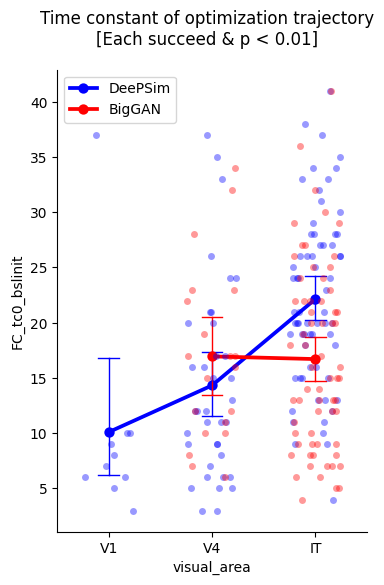

In [74]:
timeconst_meta_df = pd.read_csv(join(source_data_dir, "Figure4_src_evol_traj_time_constant_w_meta.csv"))
mask_df = pd.read_csv(join(source_data_dir, f"Figure4_src_exp_masks_and_succ_labels.csv"))
validmsk = mask_df["valid"].astype(bool).values

p_thresh = 0.01
FCsucsmsk = timeconst_meta_df.p_maxinit_0 < p_thresh
BGsucsmsk = timeconst_meta_df.p_maxinit_1 < p_thresh

sucslabel = "eachsucs"
tclabel = "tc0_bslinit"
plt.figure(figsize=[4, 6])
sns.stripplot(data=timeconst_meta_df[validmsk&FCsucsmsk], x="visual_area", y="FC_tc0_bslinit", order=["V1", "V4", "IT"],
              color="blue", alpha=0.4, jitter=0.25, label=None,  dodge=True)
sns.stripplot(data=timeconst_meta_df[validmsk&BGsucsmsk], x="visual_area", y="BG_tc0_bslinit", order=["V1", "V4", "IT"],
              color="red", alpha=0.4, jitter=0.25, label=None, dodge=True)
sns.pointplot(data=timeconst_meta_df[validmsk&FCsucsmsk], x="visual_area", y="FC_tc0_bslinit", order=["V1", "V4", "IT"],
              errorbar=("ci", 95), color="blue", label="DeePSim",scale=1.0, errwidth=1, capsize=0.2)
sns.pointplot(data=timeconst_meta_df[validmsk&BGsucsmsk], x="visual_area", y="BG_tc0_bslinit", order=["V1", "V4", "IT"],
              errorbar=("ci", 95), color="red", label="BigGAN",scale=1.0, errwidth=1, capsize=0.2)
plt.suptitle(f"Time constant of optimization trajectory\n[Each succeed & p < {p_thresh}]")
plt.legend()
# saveallforms([figdir, exportdir], f"Evol_traj_time_constant_{sucslabel}_{tclabel}_cmp", plt.gcf())
plt.show()